In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from netCDF4 import Dataset,num2date
from scipy import stats
import pandas as pd

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Droid Sans']

In [3]:
def bootstrap_regime_proportion(x,N,r,lower_percent,upper_percent):
    resample_store = np.full((N,x.shape[1]),np.nan)

    for n in range(N):
        rand_samp = np.random.randint(0,len(x),len(x))
        resample_store[n]=np.sum(x[rand_samp]==r,axis=0)/len(x)

    lower=np.percentile(resample_store,lower_percent,axis=0)
    upper = np.percentile(resample_store,upper_percent,axis=0)

    
    return lower, upper

In [4]:
def bootstrap_median(x,N,lower_percent, upper_percent):
    resample_store = np.full((N,len(x)),np.nan)

    for n in range(N):
        rand_samp = np.random.randint(0,len(x),len(x))
        resample_store[n]=np.median(x[rand_samp])

    lower=np.percentile(resample_store,lower_percent)
    upper = np.percentile(resample_store,upper_percent)

    
    return lower, upper

In [5]:
nregs=5
year1=1979; year2=2022
## number of bootstrap resamples
N_boots=10000

In [6]:
f = Dataset('era5_'+str(year1)+'_'+str(year2)+'_north_american_weather_regimes_w_neutral.nc','r')
time=num2date(f.variables['time'][:],f.variables['time'].units,f.variables['time'].calendar)
daily_regime=f.variables['regime'][:]
f.close()

In [7]:
regnames = ['Pacific Trough','Pacific Ridge','Alaskan Ridge','Greenland High','No regime']
short_regnames=['PT','PR','AKR','GH','NO']
regcols = ['purple','cornflowerblue','orange','tomato','gray']
parts = ['(a)','(b)','(c)','(d)']

# Persistence for all days, all instances

Like most code I write, this is poorly written...

In [8]:
## regime persistence (all days, all instances)
regcount_all = []
reg_start_time = []
regcount_end_time = []
idx_start_all = []
idx_end_all = []

for r in range(nregs):
    count=0
    regcount=[]
    regcount_time = []
    regcount_start = []
    idx_start = []
    idx_end = []

    for i in range(len(daily_regime)):
        if daily_regime[i]==r: # if in that regime, add to count of days
            count+=1
        else:
            if count>0: # if the counter has been running...
                regcount.append(count) # number of consecutive days
                regcount_time.append(time[i]) # end of the regime time
                idx_start.append(i-count) # start of the regime index
                idx_end.append(i) #  end of the regime index
                regcount_start.append(time[i-count]) # start of the regime time
                
            count=0
    # append all instances for that regime        
    regcount_all.append(regcount)
    regcount_end_time.append(regcount_time)
    reg_start_time.append(regcount_start)
    idx_start_all.append(idx_start)
    idx_end_all.append(idx_end)

In [9]:
# the longest-lived regimes
for i in range(nregs):
    print(np.max(regcount_all[i]))
    print(regcount_end_time[i][np.where(np.array(regcount_all[i])==np.max(regcount_all[i]))[0][0]])

43
1998-02-26 00:00:00
44
1994-12-14 00:00:00
26
1994-08-20 00:00:00
34
2010-02-26 00:00:00
19
1981-06-29 00:00:00


In [10]:
lags=np.arange(0,15,1)
lagged_regimes = np.full((nregs,nregs,len(lags)),np.nan)
lagged_regimes_ci = np.full((nregs,nregs,2,len(lags)),np.nan)

for r in range(nregs):
    regime_evolution = []
    for i in range(len(idx_start_all[r])):
        ## allow for lag either side at start and end of time series|
        if idx_start_all[r][i]>abs(np.min(lags)) and idx_start_all[r][i]<len(daily_regime)-lags[-1]:
            regime_evolution.append(daily_regime[idx_start_all[r][i]+lags[0]:idx_start_all[r][i]+lags[-1]+1])
            
    regime_evolution=np.array(regime_evolution)
    ## store the proportion of all events assigned to regime  
    for r2 in range(nregs):
        lagged_regimes[r,r2] = (np.sum(regime_evolution==r2,axis=0)/len(regime_evolution))
        lagged_regimes_ci[r,r2]=bootstrap_regime_proportion(regime_evolution,N_boots,r2,2.5,97.5)

In [11]:
## fraction of days in each regime (climatology)
ratios_fraction = [np.sum(daily_regime==r)/len(daily_regime) for r in range(nregs)]

In [12]:
for r in range(5):
    print(bootstrap_median(np.array(regcount_all[r]),10000,2.5,97.5))

(6.0, 7.0)
(5.0, 6.0)
(5.0, 6.0)
(6.0, 7.0)
(2.0, 2.0)


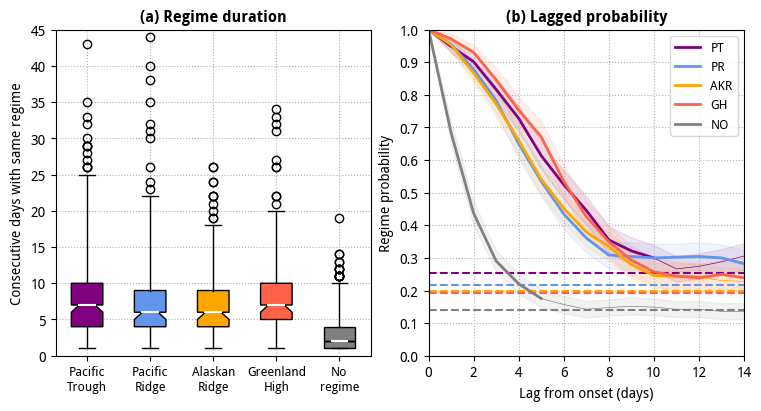

In [13]:
## big figure!
meanprops = dict(markerfacecolor='lime',markeredgecolor='lime',marker='s')
medianprops = dict(color="w",linewidth=1.5)
fs_title=11

fig, axs = plt.subplots(1,2,figsize=(7.5,4),layout="constrained")
b1=axs[0].boxplot(regcount_all,whis=(2.5,97.5),notch=True,bootstrap=10000,medianprops=medianprops,patch_artist=True)
for p,patch in enumerate(b1['boxes']):
        patch.set_facecolor(regcols[p])   
        
axs[0].set_xticks(np.arange(1,6,1))
axs[0].set_xticklabels(['Pacific\nTrough','Pacific\nRidge','Alaskan\nRidge','Greenland\nHigh','No\nregime'],fontsize=9)
axs[0].set_ylabel("Consecutive days with same regime")
axs[0].set_yticks(np.arange(0,50,5))
axs[0].set_ylim(0,45)
axs[0].set_title("(a) Regime duration",weight="bold",fontsize=fs_title)

## then into the probability as a function of lag
axs[1].set_xlabel("Lag from onset (days)")
axs[1].set_ylabel("Regime probability")
axs[1].set_yticks(np.arange(0,1.1,0.1))
for r in range(nregs):
    axs[1].plot(lags,lagged_regimes[r,r],color=regcols[r],lw=0.5)
    axs[1].plot(lags,np.ma.masked_where(lagged_regimes_ci[r,r,0]<ratios_fraction[r],lagged_regimes[r,r]),color=regcols[r],label=short_regnames[r],lw=2)
    ## confidence interval shading
    axs[1].fill_between(lags,lagged_regimes_ci[r,r,0],lagged_regimes_ci[r,r,1],color=regcols[r],alpha=0.1)   
    axs[1].axhline(ratios_fraction[r],color=regcols[r],ls='--')

axs[1].set_title("(b) Lagged probability",weight="bold",fontsize=fs_title)
for i,item in enumerate(axs.reshape(-1)):
    axs[i].grid(linestyle=':')

axs[1].set_ylim(0,1)
axs[1].set_xlim(min(lags),max(lags))
axs[1].set_xticks(np.arange(min(lags),max(lags)+1,2))
xticklabs = np.arange(min(lags),max(lags)+1,2)
axs[1].axvline(0,color='k',lw=0.5)
axs[1].legend(loc='upper right',fontsize=9)
plt.show()

In [14]:
for r in range(5):
    print("Median:",int(np.median(regcount_all[r])),"days")

Median: 7 days
Median: 6 days
Median: 6 days
Median: 7 days
Median: 2 days


In [15]:
## number of individual regime "events"
reg_events=np.full(nregs,np.nan)
for r in range(nregs):
    reg_events[r]=np.shape(regcount_all[r])[0]